# DistilBERT Model Training and Evaluation

## 1 Import libraries

In [1]:
print("Loading libraries...")

# Core libraries
import os
import time

# Data manipulation libraries
import pandas as pd
import numpy as np

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Transformers library for DistilBERT model
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, get_linear_schedule_with_warmup

# Scikit learn imports
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)

# For saving/loading tokenizer if not part of model save
import joblib

# Loading data from Google Drive
import gdown

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

else:
    device = torch.device("cpu")
    print("WARNING: GPU not available, using CPU. Training will be very slow.")

pd.set_option('display.max_colwidth', 150)

print("Libraries loaded.")

Loading libraries...
Using GPU: Tesla T4
Libraries loaded.


## 2 Load splot text datasets

Load the `X_train_features.npz`, `X_val_features.npz`, `X_test_features.npz` (sparse matrices for TF-IDF features),
and their corresponding label files (`y_train_labels.csv`, `y_val_labels.csv`, `y_test_labels.csv`).
Also, load the saved `tfidf_vectorizer.joblib` as it might be needed later for XAI or processing other test sets.

In [2]:
# --- Define Google Drive File IDs and local filenames ---
TRAIN_CORPUS_GDRIVE_FILE_ID = '1x1E4c6lK7H888RC2ucyhRZuSEXn23x0Z'
TRAIN_CORPUS_LOCAL_FILENAME = 'train_corpus.csv'

VALIDATION_CORPUS_GDRIVE_FILE_ID = '19jIrYmW5MkY4D4AApDlA_Bu2QcgC5HcP'
VALIDATION_CORPUS_LOCAL_FILENAME = 'validation_corpus.csv'

TEST_CORPUS_GDRIVE_FILE_ID = '1bR5kipQPB21VSvjpLypbzkQAP0v-sAaw'
TEST_CORPUS_LOCAL_FILENAME = 'test_corpus.csv'

# --- gdown download function ---
def download_file_from_gdrive(file_id, local_filename):
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename} from Google Drive...")
        gdrive_url = f'https://drive.google.com/uc?id={file_id}'

        try:
          gdown.download(gdrive_url, local_filename, quiet=False)
          print(f"{local_filename} downloaded.")

        except Exception as e:
          print(f"ERROR downloading {local_filename}: {e}")
          return False

    else:
      print(f"{local_filename} already exists.")

    return os.path.exists(local_filename)

# --- Load files ---
df_train_text, df_val_text, df_test_text = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
all_text_files_loaded = True

if download_file_from_gdrive(TRAIN_CORPUS_GDRIVE_FILE_ID, TRAIN_CORPUS_LOCAL_FILENAME):
    try:
      df_train_text = pd.read_csv(TRAIN_CORPUS_LOCAL_FILENAME)
      print(f"Loaded train: {df_train_text.shape}")

    except Exception as e:
      print(f"Error reading {TRAIN_CORPUS_LOCAL_FILENAME}: {e}")
      all_text_files_loaded = False

else:
  all_text_files_loaded = False

if download_file_from_gdrive(VALIDATION_CORPUS_GDRIVE_FILE_ID, VALIDATION_CORPUS_LOCAL_FILENAME):
    try:
      df_val_text = pd.read_csv(VALIDATION_CORPUS_LOCAL_FILENAME)
      print(f"Loaded val: {df_val_text.shape}")

    except Exception as e:
      print(f"Error reading {VALIDATION_CORPUS_LOCAL_FILENAME}: {e}")
      all_text_files_loaded = False

else:
  all_text_files_loaded = False

if download_file_from_gdrive(TEST_CORPUS_GDRIVE_FILE_ID, TEST_CORPUS_LOCAL_FILENAME):
    try:
      df_test_text = pd.read_csv(TEST_CORPUS_LOCAL_FILENAME)
      print(f"Loaded test: {df_test_text.shape}")

    except Exception as e:
      print(f"Error reading {TEST_CORPUS_LOCAL_FILENAME}: {e}")
      all_text_files_loaded = False

else:
  all_text_files_loaded = False

if all_text_files_loaded and not df_train_text.empty:
    print("\nTrain data text head:")
    print(df_train_text.head(2))

elif not all_text_files_loaded:
    print("\nOne or more text dataset files could not be loaded.")

Downloading...
From: https://drive.google.com/uc?id=1x1E4c6lK7H888RC2ucyhRZuSEXn23x0Z
To: /content/train_corpus.csv
100%|██████████| 29.4M/29.4M [00:00<00:00, 52.7MB/s]


train_corpus.csv downloaded.
Loaded train: (29280, 3)


Downloading...
From: https://drive.google.com/uc?id=19jIrYmW5MkY4D4AApDlA_Bu2QcgC5HcP
To: /content/validation_corpus.csv
100%|██████████| 6.29M/6.29M [00:00<00:00, 38.5MB/s]


validation_corpus.csv downloaded.
Loaded val: (6274, 3)


Downloading...
From: https://drive.google.com/uc?id=1bR5kipQPB21VSvjpLypbzkQAP0v-sAaw
To: /content/test_corpus.csv
100%|██████████| 6.81M/6.81M [00:00<00:00, 27.9MB/s]


test_corpus.csv downloaded.
Loaded test: (6275, 3)

Train data text head:
                                                                                                                                            body_cleaned  \
0  start date 12702 hourahead hour 5 no ancillary schedules awarded. no variances detected. log messages parsing file  oportlandwestdeskcalifornia sc...   
1                                                                                                                the world's largest online health shop.   

                     subject_cleaned  label  
0  start date 12702 hourahead hour 5      0  
1          5 meds every woman needs.      1  


## 3 Prepare text data and tokenisation

- Combine 'subject_cleaned' and 'body_cleaned' if you used both (same logic as for TF-IDF prep).
- Handle NaNs in the text column.
- Initialize the DistilBERT tokenizer.
- Tokenize the text for training, validation, and test sets.

In [3]:
MODEL_NAME = 'distilbert-base-uncased'
tokeniser = None
train_encodings, val_encodings, test_encodings = None, None, None
y_train_distilbert, y_val_distilbert, y_test_distilbert = None, None, None

if all_text_files_loaded and not df_train_text.empty:
    # --- Prepare combined text feature ---
    TEXT_COL_BODY = 'body_cleaned'
    TEXT_COL_SUBJECT = 'subject_cleaned'
    FEATURE_TEXT_COLUMN_DISTILBERT = 'text_for_distilbert'

    for df in [df_train_text, df_val_text, df_test_text]:
        if TEXT_COL_BODY in df.columns:
          df[TEXT_COL_BODY] = df[TEXT_COL_BODY].fillna('')

        if TEXT_COL_SUBJECT in df.columns:
          df[TEXT_COL_SUBJECT] = df[TEXT_COL_SUBJECT].fillna('')

        if TEXT_COL_SUBJECT in df.columns and TEXT_COL_BODY in df.columns:
            df[FEATURE_TEXT_COLUMN_DISTILBERT] = df[TEXT_COL_SUBJECT].astype(str) + " " + df[TEXT_COL_BODY].astype(str)

        elif TEXT_COL_BODY in df.columns:
            df[FEATURE_TEXT_COLUMN_DISTILBERT] = df[TEXT_COL_BODY].astype(str)

        else:
            print(f"ERROR: Text columns not found in one of the dataframes for DistilBERT.")

    if FEATURE_TEXT_COLUMN_DISTILBERT not in df_train_text.columns:
        print("ERROR: Text feature column for DistilBERT not created.")

    else:
        train_texts = df_train_text[FEATURE_TEXT_COLUMN_DISTILBERT].tolist()
        val_texts = df_val_text[FEATURE_TEXT_COLUMN_DISTILBERT].tolist()
        test_texts = df_test_text[FEATURE_TEXT_COLUMN_DISTILBERT].tolist()

        y_train_distilbert = df_train_text['label'].tolist()
        y_val_distilbert = df_val_text['label'].tolist()
        y_test_distilbert = df_test_text['label'].tolist()

        # --- Initialize Tokeniser ---
        print(f"Loading tokeniser for '{MODEL_NAME}'...")
        tokeniser = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

        # --- Tokenize Text ---
        # Max length can be tuned. DistilBERT's max is 512.
        MAX_LENGTH = 256
        print(f"Tokenizing texts with max_length={MAX_LENGTH}...")

        # Define encodings via tokenising
        train_encodings = tokeniser(train_texts, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
        val_encodings = tokeniser(val_texts, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
        test_encodings = tokeniser(test_texts, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")

        print("Tokenisation complete.")
        print(f"Train encodings input_ids shape: {train_encodings['input_ids'].shape}")

else:
    print("Text data not loaded. Cannot tokenize.")

Loading tokeniser for 'distilbert-base-uncased'...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizing texts with max_length=256...
Tokenisation complete.
Train encodings input_ids shape: torch.Size([29280, 256])


## 4 Create PyTorch Datasets and DataLoaders

Create custom PyTorch Dataset class to handle the tokenised inputs and labels.
Then, create DataLoaders for batching during training and evaluation.

In [4]:
train_dataset, val_dataset, test_dataset = None, None, None
train_loader, val_loader, test_loader = None, None, None

class PhishingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

if train_encodings and y_train_distilbert:
    train_dataset = PhishingDataset(train_encodings, y_train_distilbert)
    val_dataset = PhishingDataset(val_encodings, y_val_distilbert)
    test_dataset = PhishingDataset(test_encodings, y_test_distilbert)

    # Adjust based on GPU memory (16 or 32 are common for BERT-like models)
    BATCH_SIZE = 16
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    print(f"PyTorch Datasets and DataLoaders created with BATCH_SIZE={BATCH_SIZE}.")

    # Check a sample batch
    sample_batch = next(iter(train_loader))
    print("Sample batch keys:", sample_batch.keys())
    print("Sample batch input_ids shape:", sample_batch['input_ids'].shape)

else:
    print("Tokenised data not available. Cannot create Datasets/DataLoaders.")

PyTorch Datasets and DataLoaders created with BATCH_SIZE=16.
Sample batch keys: dict_keys(['input_ids', 'attention_mask', 'labels'])
Sample batch input_ids shape: torch.Size([16, 256])


## 5 Initialise and fine-tune DistilBERT model

- Load pre-trained DistilBERT model for sequence classification.
- Define optimizer and learning rate scheduler.
- Implement training and validation loops.
- Fine-tune the model.

In [5]:
distilbert_model = None

if train_loader and val_loader:
    print(f"Loading pre-trained DistilBERT model ('{MODEL_NAME}') for sequence classification...")

    # 2 labels: Ham (0), Phish (1)
    distilbert_model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    # Move model to GPU if available
    distilbert_model.to(device)

    # --- Training Hyperparameters ---
    EPOCHS = 3
    LEARNING_RATE = 2e-5

    optimizer = AdamW(distilbert_model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    print(f"Starting fine-tuning for {EPOCHS} epochs...")

    for epoch in range(EPOCHS):
        start_time_epoch = time.time()
        print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")

        # --- Training Loop ---
        distilbert_model.train()
        total_train_loss = 0
        for batch_num, batch in enumerate(train_loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = distilbert_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(distilbert_model.parameters(), 1.0) # Gradient clipping
            optimizer.step()
            scheduler.step()

            if (batch_num + 1) % 100 == 0: # Print progress every 100 batches
                print(f"  Epoch {epoch+1}, Batch {batch_num+1}/{len(train_loader)}, Avg Train Loss: {total_train_loss/(batch_num+1):.4f}")

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Average Training Loss: {avg_train_loss:.4f}")

        # --- Validation Loop ---
        distilbert_model.eval()
        total_eval_loss = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = distilbert_model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_eval_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_eval_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)

        # Use weighted for overall F1
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)

        epoch_duration = time.time() - start_time_epoch
        print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}")
        print(f"Epoch {epoch+1} duration: {epoch_duration:.2f} seconds.")

    print("\nFine-tuning complete.")

else:
    print("Training data (DataLoaders) not available. Skipping model fine-tuning.")

Loading pre-trained DistilBERT model ('distilbert-base-uncased') for sequence classification...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting fine-tuning for 3 epochs...

--- Epoch 1/3 ---
  Epoch 1, Batch 100/1830, Avg Train Loss: 0.2482
  Epoch 1, Batch 200/1830, Avg Train Loss: 0.1525
  Epoch 1, Batch 300/1830, Avg Train Loss: 0.1229
  Epoch 1, Batch 400/1830, Avg Train Loss: 0.1082
  Epoch 1, Batch 500/1830, Avg Train Loss: 0.1008
  Epoch 1, Batch 600/1830, Avg Train Loss: 0.0899
  Epoch 1, Batch 700/1830, Avg Train Loss: 0.0833
  Epoch 1, Batch 800/1830, Avg Train Loss: 0.0767
  Epoch 1, Batch 900/1830, Avg Train Loss: 0.0724
  Epoch 1, Batch 1000/1830, Avg Train Loss: 0.0676
  Epoch 1, Batch 1100/1830, Avg Train Loss: 0.0638
  Epoch 1, Batch 1200/1830, Avg Train Loss: 0.0608
  Epoch 1, Batch 1300/1830, Avg Train Loss: 0.0578
  Epoch 1, Batch 1400/1830, Avg Train Loss: 0.0563
  Epoch 1, Batch 1500/1830, Avg Train Loss: 0.0540
  Epoch 1, Batch 1600/1830, Avg Train Loss: 0.0524
  Epoch 1, Batch 1700/1830, Avg Train Loss: 0.0503
  Epoch 1, Batch 1800/1830, Avg Train Loss: 0.0490
Epoch 1 - Average Training Loss: 0.

## 6 Evaluate DistilBERT model on the test set

Evaluate the fine-tuned DistilBERT model on the held-out test set (`test_loader`).

Evaluating DistilBERT model on the test set...
Test set evaluation completed in 45.68 seconds.

--- Test Set Evaluation Metrics (DistilBERT) ---
Accuracy:  0.9971
Precision: 0.9969 (Phishing)
Recall:    0.9976 (Phishing)
F1-score:  0.9973 (Phishing)
ROC AUC:   0.9999

Classification Report (Test Set - DistilBERT):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00      3275

    accuracy                           1.00      6275
   macro avg       1.00      1.00      1.00      6275
weighted avg       1.00      1.00      1.00      6275


Confusion Matrix (Test Set - DistilBERT):


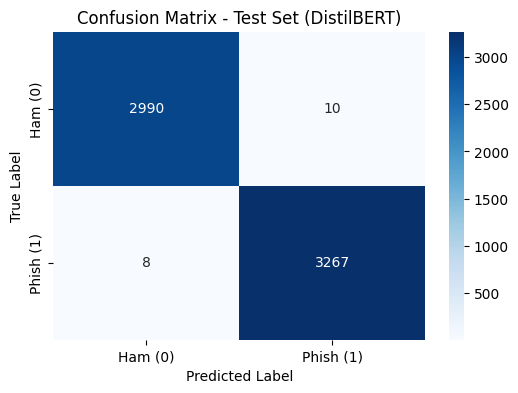

In [6]:
if distilbert_model and test_loader:
    print("Evaluating DistilBERT model on the test set...")

    # Set model to evaluation mode
    distilbert_model.eval()

    all_test_preds = []
    all_test_labels = []

    # For ROC AUC
    all_test_probs = []

    start_time_eval = time.time()

    # No need to calculate gradients during evaluation
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = distilbert_model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get probabilities
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)

            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

            # Probabilities for the positive class (phishing)
            all_test_probs.extend(probs[:, 1].cpu().numpy())

    eval_duration = time.time() - start_time_eval
    print(f"Test set evaluation completed in {eval_duration:.2f} seconds.")

    # Calculate metrics
    test_accuracy_db = accuracy_score(all_test_labels, all_test_preds)
    test_precision_db = precision_score(all_test_labels, all_test_preds, zero_division=0)
    test_recall_db = recall_score(all_test_labels, all_test_preds, zero_division=0)
    test_f1_db = f1_score(all_test_labels, all_test_preds, zero_division=0)

    try:
        test_roc_auc_db = roc_auc_score(all_test_labels, all_test_probs)

    except ValueError:
        test_roc_auc_db = float('nan')
        print("Warning: ROC AUC for DistilBERT could not be computed.")


    print(f"\n--- Test Set Evaluation Metrics (DistilBERT) ---")
    print(f"Accuracy:  {test_accuracy_db:.4f}")
    print(f"Precision: {test_precision_db:.4f} (Phishing)")
    print(f"Recall:    {test_recall_db:.4f} (Phishing)")
    print(f"F1-score:  {test_f1_db:.4f} (Phishing)")
    print(f"ROC AUC:   {test_roc_auc_db:.4f}")

    print("\nClassification Report (Test Set - DistilBERT):")
    print(classification_report(all_test_labels, all_test_preds, zero_division=0))

    print("\nConfusion Matrix (Test Set - DistilBERT):")
    cm_db = confusion_matrix(all_test_labels, all_test_preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_db, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham (0)', 'Phish (1)'], yticklabels=['Ham (0)', 'Phish (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Test Set (DistilBERT)')
    plt.show()

else:
    print("DistilBERT model not trained or test data not available. Skipping evaluation.")

## 7 Save the fine-tuned DistilBERT model and tokeniser

Save the model for later use (XAI, predictions, further evaluation).

In [7]:
# Save in Hugging Face format (directory)
DISTILBERT_MODEL_SAVE_PATH = './distilbert_phishing_model/'

if distilbert_model and tokeniser:
    try:
        if not os.path.exists(DISTILBERT_MODEL_SAVE_PATH):
            os.makedirs(DISTILBERT_MODEL_SAVE_PATH)

        distilbert_model.save_pretrained(DISTILBERT_MODEL_SAVE_PATH)
        tokeniser.save_pretrained(DISTILBERT_MODEL_SAVE_PATH)

        print(f"Fine-tuned DistilBERT model and tokenizer saved to: {DISTILBERT_MODEL_SAVE_PATH}")
        print(f"Files will be in /content/{DISTILBERT_MODEL_SAVE_PATH.lstrip('./')}")

    except Exception as e:
        print(f"Error saving the DistilBERT model/tokenizer: {e}")

else:
    print("No DistilBERT model or tokeniser available to save.")

Fine-tuned DistilBERT model and tokenizer saved to: ./distilbert_phishing_model/
Files will be in /content/distilbert_phishing_model/
